In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
import seaborn as sns
import xgboost as xgb

from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.datasets import load_wine
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [ ]:
train = pd.read_csv('train.csv', parse_dates = ['Datetime'])
test = pd.read_csv('test.csv', parse_dates = ['Datetime'])

# Preview train dataset
train.head()

,ID,Datetime,Sensor1_PM2.5,Sensor2_PM2.5,Temperature,Relative_Humidity,Offset_fault
0,ID_QF0ZTQJ2SF5Q,2021-11-03 04:06:31,52.58,49.52,17.4,96.0,0
1,ID_4GTK689CNX5S,2021-11-08 18:43:23,35.25,33.40,25.0,75.0,0
2,ID_DL7VVKW9U7XQ,2021-11-07 09:50:33,19.18,23.50,24.9,75.0,0
3,ID_6XQOMBXM2DG3,2022-01-01 18:55:15,19.40,15.48,24.9,70.0,0
4,ID_UQZW9ISJY9QE,2021-11-05 22:23:48,38.30,34.77,20.9,89.0,0


In [ ]:
train = train.drop(columns=['ID'])

In [ ]:
train['Datetime_day'] = train.Datetime.dt.day

# month
train['Datetime_month'] = train.Datetime.dt.month
 
# year
train['Datetime_year'] = train.Datetime.dt.year

# hour
train['Datetime_hour'] = train.Datetime.dt.hour

In [ ]:
train = train.drop(columns=['Datetime'])

In [ ]:
train = train.fillna(0)

In [ ]:
X_train = train[["Sensor1_PM2.5","Sensor2_PM2.5","Temperature","Relative_Humidity","Datetime_day","Datetime_month","Datetime_year","Datetime_hour"]]

In [ ]:
y_train = train["Offset_fault"]

In [ ]:
from imblearn.over_sampling import SMOTE
sm = SMOTE(random_state = 2)
X_train_res, y_train_res = sm.fit_resample(X_train, y_train)

In [ ]:
train = pd.concat([X_train_res, y_train_res], axis=1, join='inner')
display(train)

,Sensor1_PM2.5,Sensor2_PM2.5,Temperature,Relative_Humidity,Datetime_day,Datetime_month,Datetime_year,Datetime_hour,Offset_fault
0,52.580000,49.520000,17.4,96.0,3,11,2021,4,0
1,35.250000,33.400000,25.0,75.0,8,11,2021,18,0
2,19.180000,23.500000,24.9,75.0,7,11,2021,9,0
3,19.400000,15.480000,24.9,70.0,1,1,2022,18,0
4,38.300000,34.770000,20.9,89.0,5,11,2021,22,0
...,...,...,...,...,...,...,...,...,...
373801,10.825430,7.002539,24.2,85.0,29,12,2021,10,1
373802,65.391031,51.282577,23.4,71.0,6,1,2022,9,1
373803,40.596045,34.221132,23.0,89.0,25,12,2021,17,1
373804,38.561440,33.619528,22.4,86.0,16,11,2021,20,1


<Figure size 576x360 with 0 Axes>

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0.5, 1.0, 'Target variable distribution')

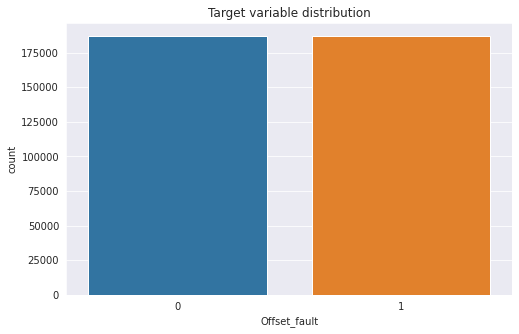

In [ ]:
# Target variable distribution
sns.set_style('darkgrid')
plt.figure(figsize=(8, 5))
sns.countplot(train["Offset_fault"])
plt.title('Target variable distribution')
plt.show()

In [ ]:
X = train.drop(columns=['Offset_fault'])
y = train['Offset_fault']

In [ ]:
y = y.to_frame()

In [ ]:
X.head()
y.head()

,Sensor1_PM2.5,Sensor2_PM2.5,Temperature,Relative_Humidity,Datetime_day,Datetime_month,Datetime_year,Datetime_hour
0,52.58,49.52,17.4,96.0,3,11,2021,4
1,35.25,33.40,25.0,75.0,8,11,2021,18
2,19.18,23.50,24.9,75.0,7,11,2021,9
3,19.40,15.48,24.9,70.0,1,1,2022,18
4,38.30,34.77,20.9,89.0,5,11,2021,22


,Offset_fault
0,0
1,0
2,0
3,0
4,0


((373806, 8), (373806, 1))

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


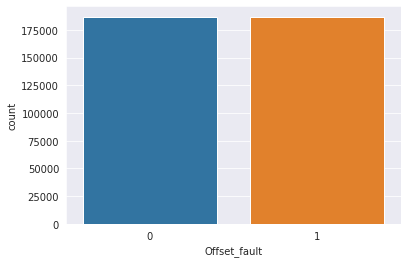

In [ ]:
X.shape, y.shape

_ = sns.countplot(y.Offset_fault)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, stratify=y)

X_train.shape, y_train.shape, X_test.shape, y_test.shape, 

((280354, 8), (280354, 1), (93452, 8), (93452, 1))

In [ ]:
dtrain = xgb.DMatrix(data=X_train, label=y_train)
dtest = xgb.DMatrix(data=X_test)

In [ ]:
params = {
    'max_depth': 6,
    'objective': 'multi:softmax',  # error evaluation for multiclass training
    'num_class': 2,
    # Set number of GPUs if available   
    'n_gpus': 0
}

In [ ]:
bst = xgb.train(params, dtrain)

In [ ]:
pred = bst.predict(dtest)

In [ ]:
print(classification_report(y_test, pred))

              precision    recall  f1-score   support

           0       0.92      0.93      0.93     46726
           1       0.93      0.92      0.93     46726

    accuracy                           0.93     93452
   macro avg       0.93      0.93      0.93     93452
weighted avg       0.93      0.93      0.93     93452



In [ ]:
samplesubmission = pd.read_csv('SampleSubmission.csv')

In [ ]:
test.head()

,ID,Datetime,Sensor1_PM2.5,Sensor2_PM2.5,Temperature,Relative_Humidity
0,ID_STL3V9B2OU12,2022-01-28 08:49:41,90.75,114.78,22.2,56.0
1,ID_U2EKAY4SGA94,2022-02-16 21:30:17,56.03,52.18,NaN,NaN
2,ID_UJFLEWQR0U4N,2022-01-24 17:57:18,387.35,346.73,28.1,63.0
3,ID_S2C2GPGA4R5I,2022-01-31 07:07:09,63.17,83.85,21.6,82.0
4,ID_5V2C2ZL221H8,2022-01-31 00:37:05,69.23,53.07,22.7,80.0


In [ ]:
test

,ID,Datetime,Sensor1_PM2.5,Sensor2_PM2.5,Temperature,Relative_Humidity
0,ID_STL3V9B2OU12,2022-01-28 08:49:41,90.75,114.78,22.2,56.0
1,ID_U2EKAY4SGA94,2022-02-16 21:30:17,56.03,52.18,NaN,NaN
2,ID_UJFLEWQR0U4N,2022-01-24 17:57:18,387.35,346.73,28.1,63.0
3,ID_S2C2GPGA4R5I,2022-01-31 07:07:09,63.17,83.85,21.6,82.0
4,ID_5V2C2ZL221H8,2022-01-31 00:37:05,69.23,53.07,22.7,80.0
...,...,...,...,...,...,...
127356,ID_HNCS9Q2GNCQB,2022-02-13 00:37:14,33.65,42.23,NaN,NaN
127357,ID_GIIQYTE11L3H,2022-03-09 16:26:42,21.23,15.72,NaN,NaN
127358,ID_EC7F1P4GXKCL,2022-02-18 14:47:28,41.45,47.25,NaN,NaN
127359,ID_J64RVG2BRAG0,2022-03-11 19:14:11,28.60,27.27,NaN,NaN


In [ ]:
test.head()

,ID,Datetime,Sensor1_PM2.5,Sensor2_PM2.5,Temperature,Relative_Humidity
0,ID_STL3V9B2OU12,2022-01-28 08:49:41,90.75,114.78,22.2,56.0
1,ID_U2EKAY4SGA94,2022-02-16 21:30:17,56.03,52.18,NaN,NaN
2,ID_UJFLEWQR0U4N,2022-01-24 17:57:18,387.35,346.73,28.1,63.0
3,ID_S2C2GPGA4R5I,2022-01-31 07:07:09,63.17,83.85,21.6,82.0
4,ID_5V2C2ZL221H8,2022-01-31 00:37:05,69.23,53.07,22.7,80.0


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


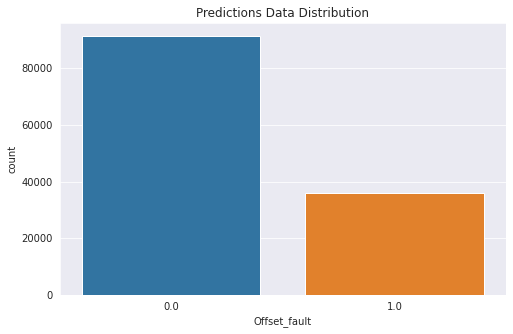

In [ ]:
test['Datetime_day'] = test.Datetime.dt.day
test['Datetime_month'] = test.Datetime.dt.month
test['Datetime_year'] = test.Datetime.dt.year
test['Datetime_hour'] = test.Datetime.dt.hour

#train_feats = ['Sensor1_PM2.5',	'Sensor2_PM2.5',	'Temperature',	'Relative_Humidity',	'Datetime_day',\
               #'Datetime_month',	'Datetime_year', 'Datetime_hour']

#test_df = test[['Sensor1_PM2.5',	'Sensor2_PM2.5',	'Temperature',	'Relative_Humidity',	'Datetime_day','Datetime_month',	'Datetime_year', 'Datetime_hour']]
test = test.drop(columns=['ID','Datetime'])
ftest = xgb.DMatrix(data=test)
predictions = bst.predict(ftest)

# # Create a submission file
sub_file = samplesubmission.copy()
sub_file.Offset_fault = predictions

# Check the distribution of your predictions
plt.figure(figsize=(8, 5))
sns.countplot(sub_file.Offset_fault)
plt.title('Predictions Data Distribution');

In [ ]:
sub_file.to_csv('Baseline.csv', index = False)